# ProQuest Historical Newspapers: Data Demo

A sqlite3 database with metatata for the newspaper collection is available on the shared folder.

In [1]:
import sqlite3
import pandas as pd
import plotnine as p9

# set plot size opgions
p9.options.dpi = 100
p9.options.figure_size = (12, 6)

In [2]:
con = sqlite3.connect("../../shared/data/newspapers-meta.sqlite3")

The database includes two tables:
- Paper/Publication metadata: `pqnews_publications`
- Article/Content metadata: `pqnews_records`

In [3]:
# the pqnews_publications table is small, with just 10 rows
pd.read_sql_query("SELECT * from pqnews_publications;", con)

,id,title,qualifier,short
0,11558,New York Daily Times (1851-1857),"New York, N.Y.",nytimes
1,45545,New York Times (1923-Current file),"New York, N.Y.",nytimes
2,55428,New York Times (1857-1922),"New York, N.Y.",nytimes
3,46998,Los Angeles Times (1881-1886),"Los Angeles, Calif.",latimes
4,47001,Los Angeles Times (1923-Current File),"Los Angeles, Calif.",latimes
5,55410,Los Angeles Times (1886-1922),"Los Angeles, Calif.",latimes
6,47009,The Washington Post (1923-1954),"Washington, D.C.",wapost
7,47011,The Washington Post and Times Herald (1954-1959),"Washington, D.C.",wapost
8,47012,"The Washington Post, Times Herald (1959-1973)","Washington, D.C.",wapost
9,60400,The Washington Post (1877-1922),"Washington, D.C.",wapost


In [4]:
# columns from pqnews_publications
pd.read_sql_query("PRAGMA table_info(pqnews_publications);", con)[['name']]


,name
0,id
1,title
2,qualifier
3,short


In [5]:
# pqnews_records is extremely large:
pd.read_sql_query("SELECT COUNT(id) as count from pqnews_records;",con)


,count
0,25254509


In [6]:
# columns from the pqnews_records table
pd.read_sql_query("PRAGMA table_info(pqnews_records);", con)[['name']]

,name
0,id
1,record_title
2,publication_id
3,numeric_pubdate
4,object_type
5,start_page
6,pagination
7,url_docview


## Distribution of records by publisher

In [7]:
q = """
SELECT pubs.short as pub_name, COUNT(recs.id) as record_count FROM pqnews_records recs 
inner join pqnews_publications pubs on recs.publication_id = pubs.id 
    GROUP BY pub_name ORDER BY pub_name ASC;
"""
pd.read_sql_query(q,con)

,pub_name,record_count
0,latimes,6982971
1,nytimes,9052702
2,wapost,9218836


## Distribution of records by `object_type`

In [8]:
q="""
SELECT recs.object_type as type, 
       count(recs.id) as count
FROM pqnews_records recs 
GROUP BY type ORDER BY count DESC;
"""
pd.read_sql_query(q,con)

,type,count
0,Feature,12413867
1,Advertisement,4331708
2,Classified Advertisement,1884158
3,Front Page/Cover Story,1588812
4,General Information,1522331
5,News,991737
6,Stock Quote,630576
7,Editorial,598970
8,Obituary,314692
9,Letter to the Editor,248262


## Distribution of records by Year

In [9]:
q = """
SELECT 
    CAST(SUBSTR(recs.numeric_pubdate,1,4) as INTEGER) as year, 
    pubs.short as short, 
    count(recs.id) as count
FROM pqnews_records recs
INNER JOIN pqnews_publications pubs on recs.publication_id = pubs.id 
GROUP BY year, short ORDER BY year ASC, short ASC;
"""
year_pubs = pd.read_sql_query(q,con)

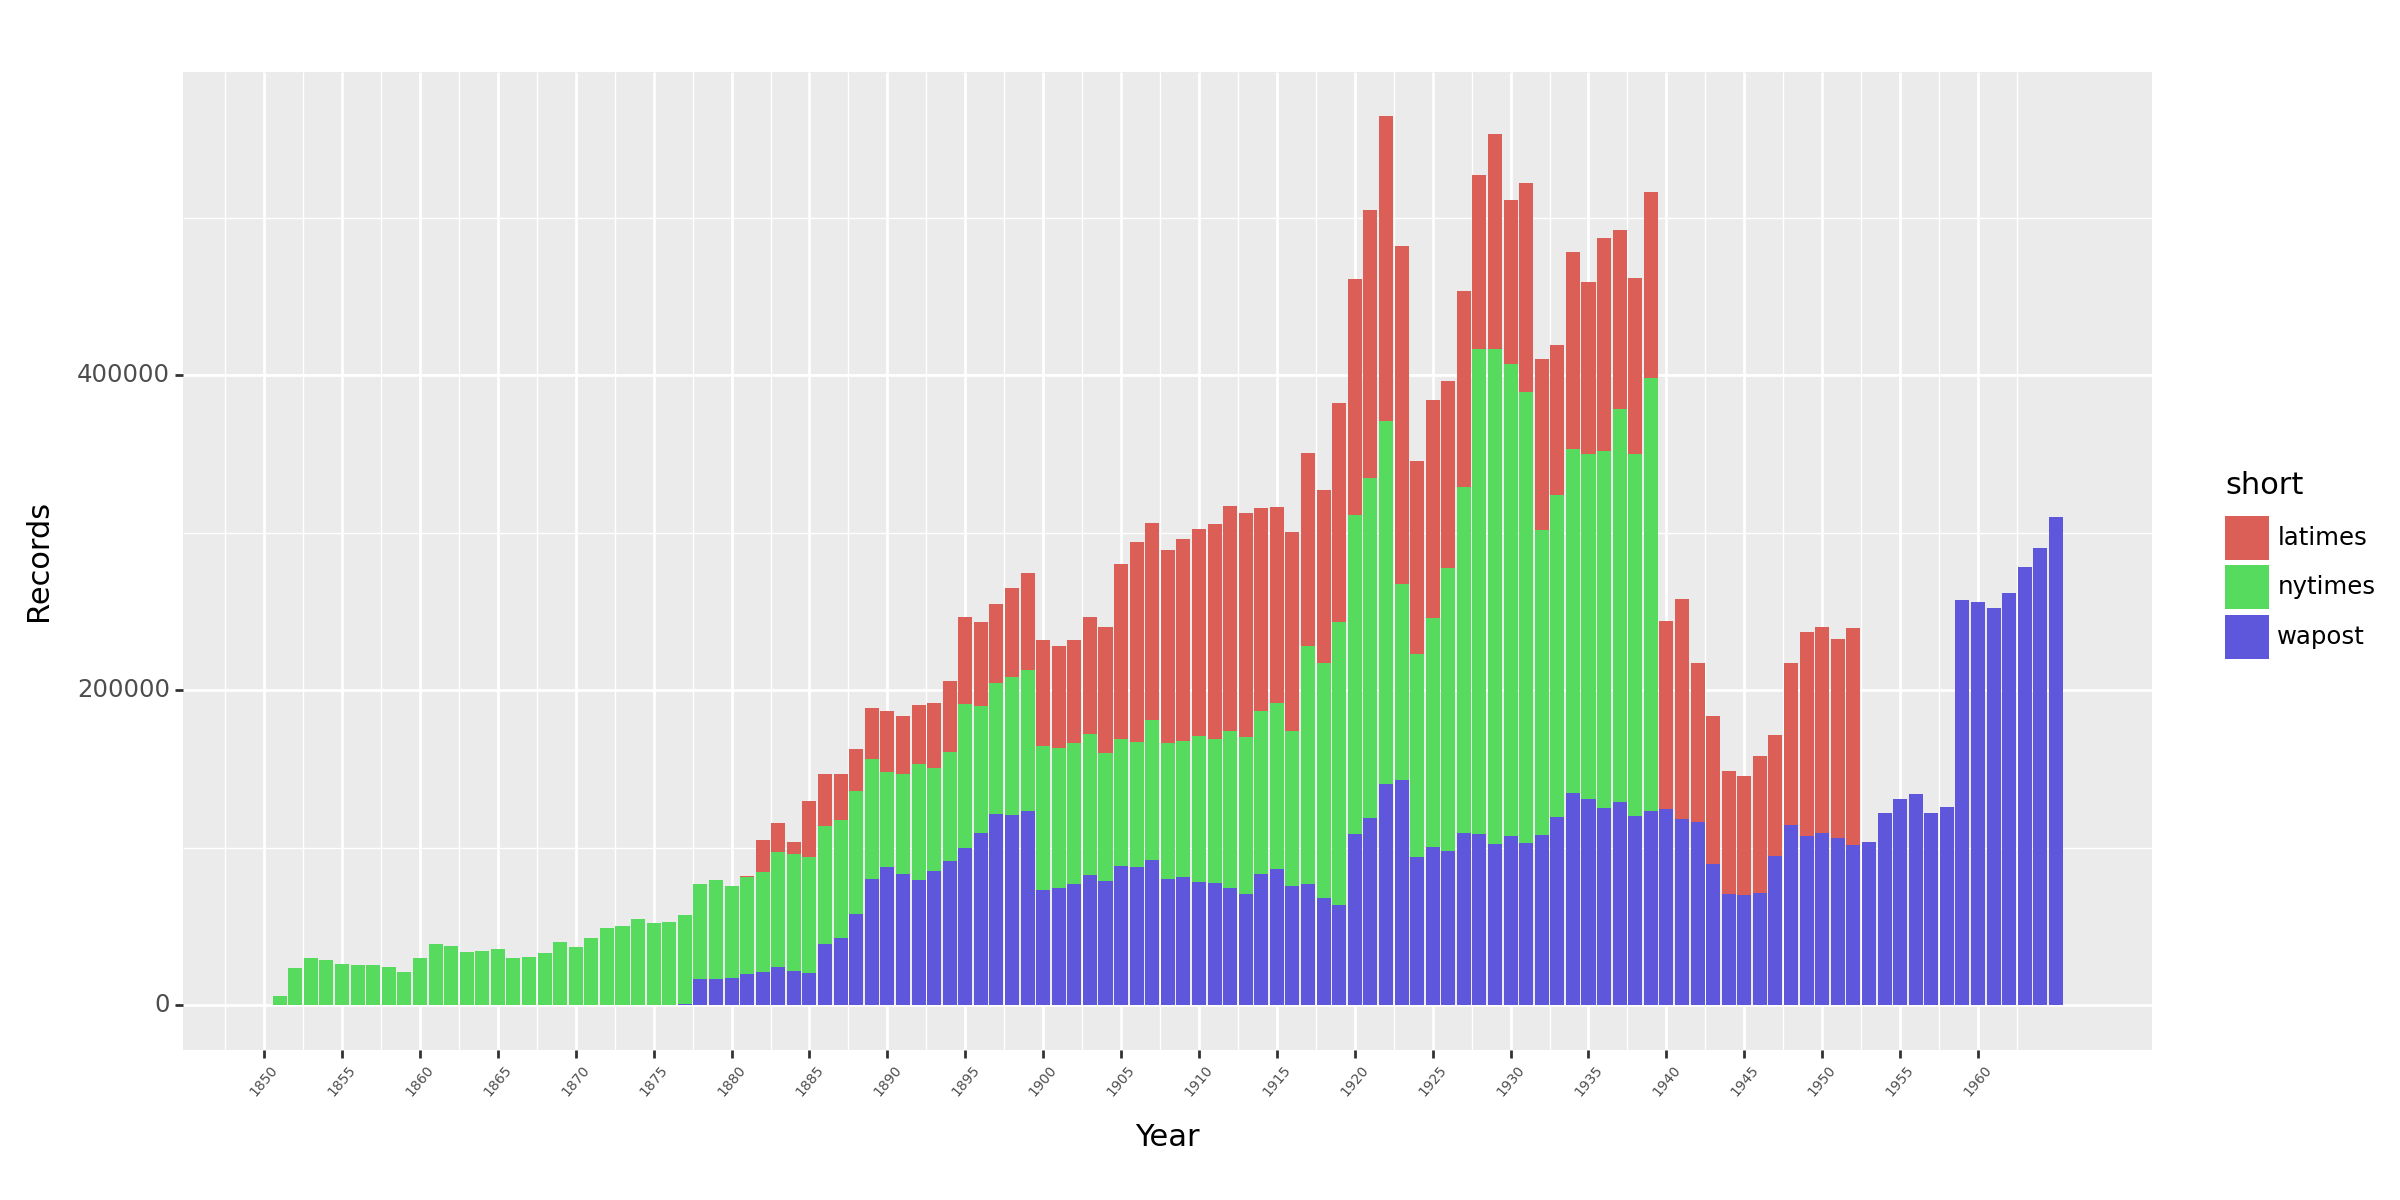

<Figure Size: (1200 x 600)>

In [10]:
myplot = (p9.ggplot(year_pubs)
    + p9.geom_bar(mapping=p9.aes(x='year', fill='short', y='count'), stat='stat_identity')
    + p9.scale_x_continuous(name="Year", breaks=range(1850,1965, 5))
    + p9.ylab("Records")
    + p9.theme(axis_text_x = p9.element_text(size=5, angle=50)))
myplot

In [11]:
q = """
SELECT CAST(SUBSTR(recs.numeric_pubdate,1,4) as INTEGER) as year,
       recs.object_type as type,
       count(recs.id) as count
FROM pqnews_records recs
GROUP BY year, type 
ORDER BY year ASC, type ASC;
"""
year_types = pd.read_sql_query(q,con)

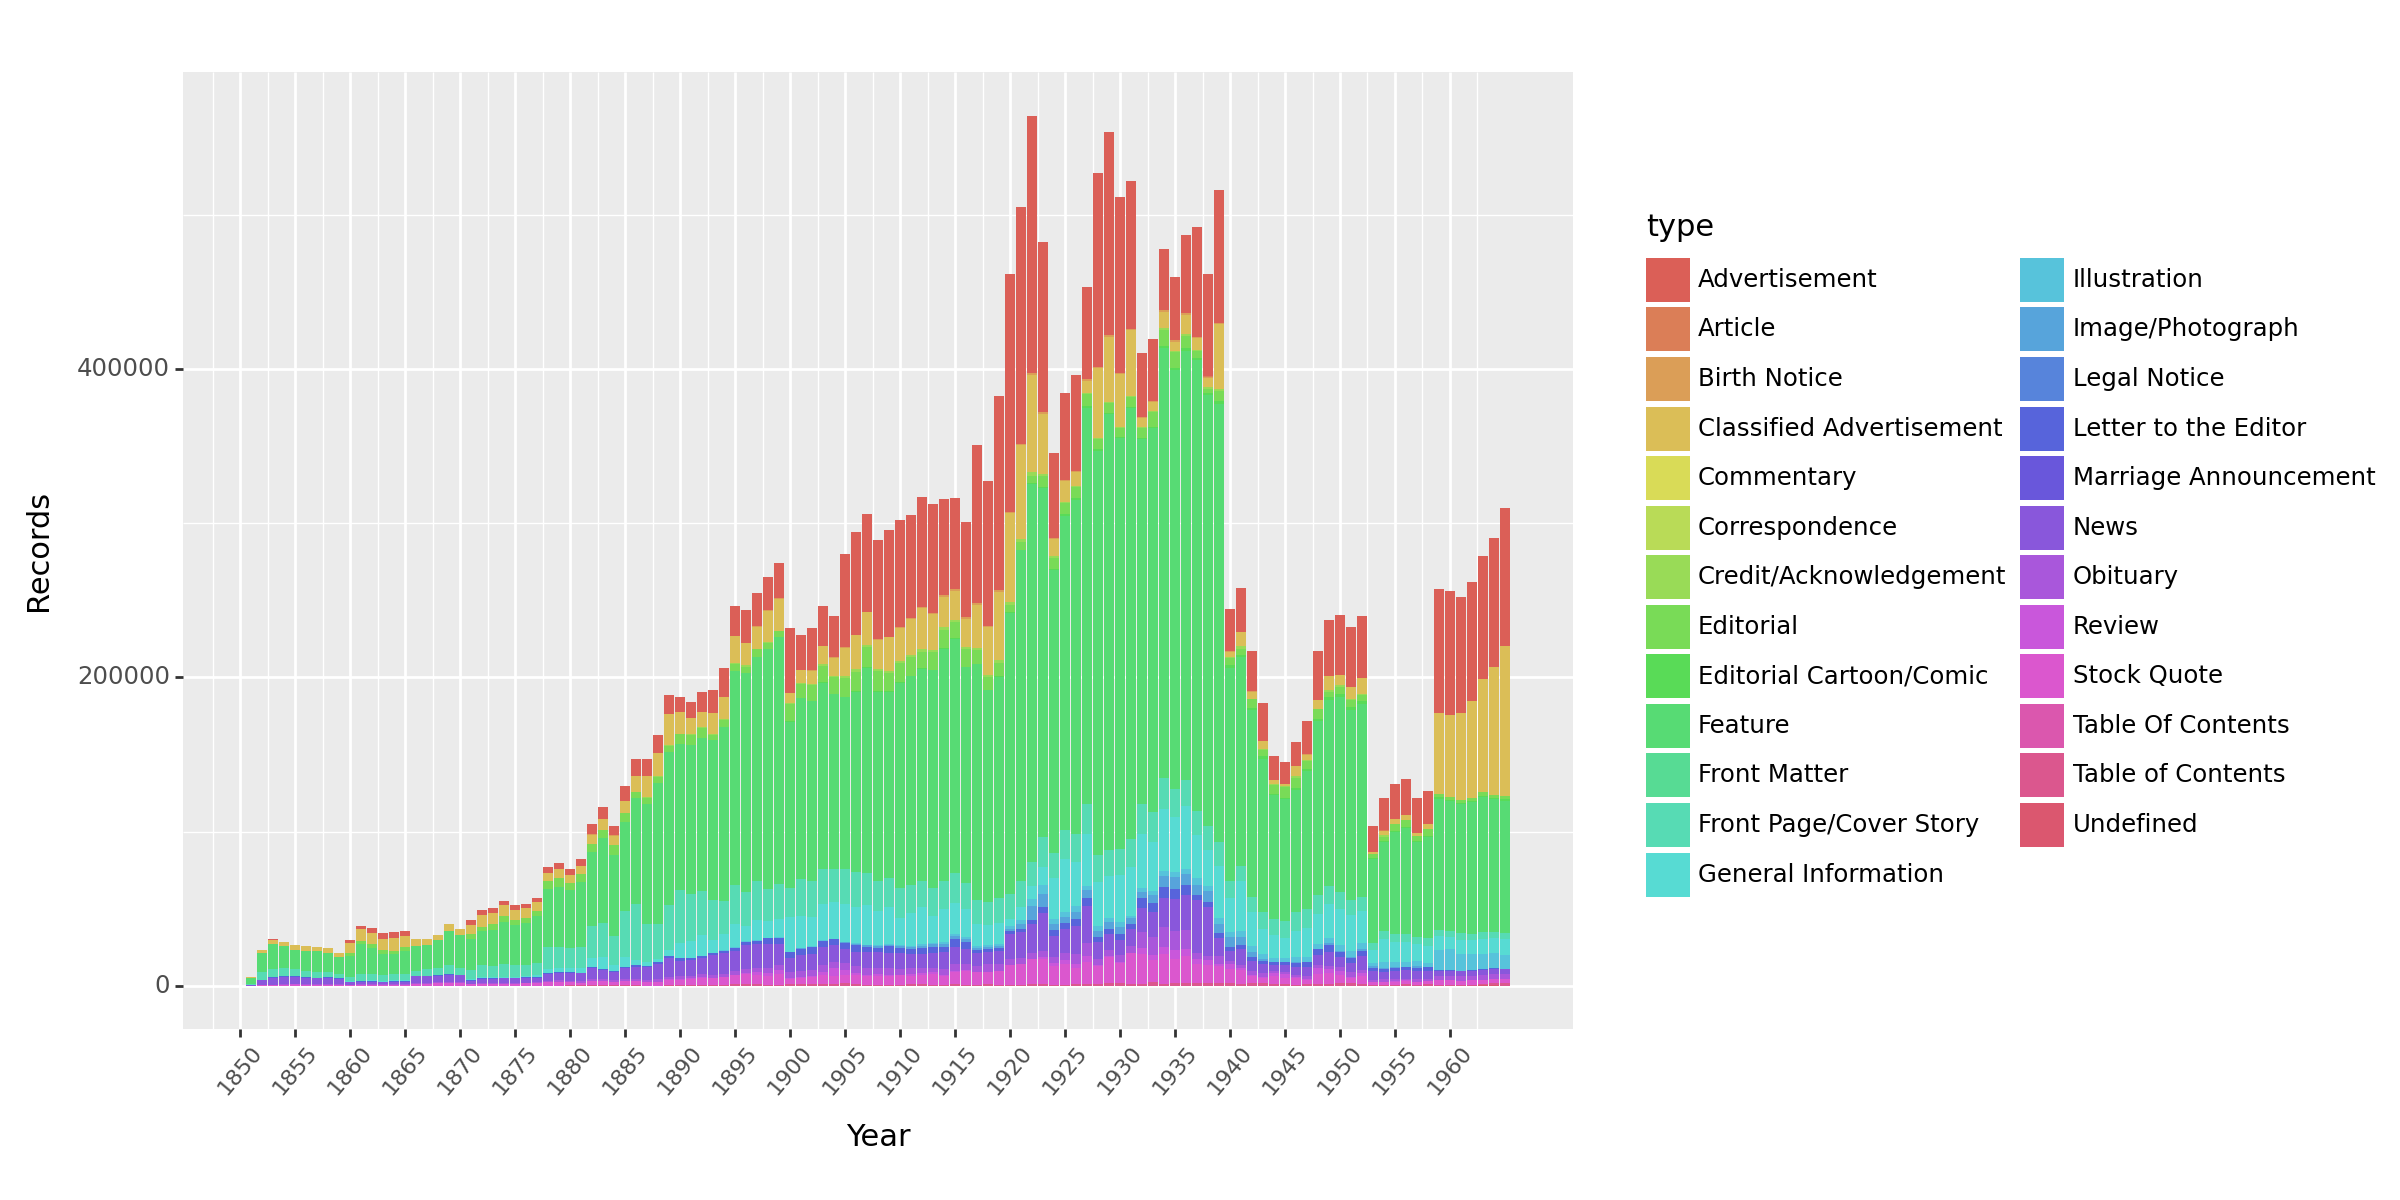

<Figure Size: (1200 x 600)>

In [12]:
myplot = (p9.ggplot(year_types)
    + p9.geom_bar(mapping=p9.aes(x='year', fill='type', y='count'), stat='stat_identity')
    + p9.scale_x_continuous(name="Year", breaks=range(1850,1965, 5))
    + p9.ylab("Records")
    + p9.theme(axis_text_x = p9.element_text(size=8, angle=50)))
myplot

Let's focus on the years 1882-1939, for which we have records for all three papers. Additionally, we'll include just the 10 most common record types in the distrubition. 

In [13]:
# modify the filte
q = """
SELECT CAST(SUBSTR(recs.numeric_pubdate,1,4) as INTEGER) as year,
       recs.object_type as type,
       count(recs.id) as count
FROM pqnews_records recs
WHERE year >= 1882 
    AND year <= 1939
    AND type IN (SELECT type from (
        SELECT recs.object_type as type, count(recs.id) as count
        FROM pqnews_records recs 
        GROUP BY type ORDER BY count DESC LIMIT 10))
GROUP BY year, type 
ORDER BY year ASC, type ASC;
"""
year_types2 = pd.read_sql_query(q,con)

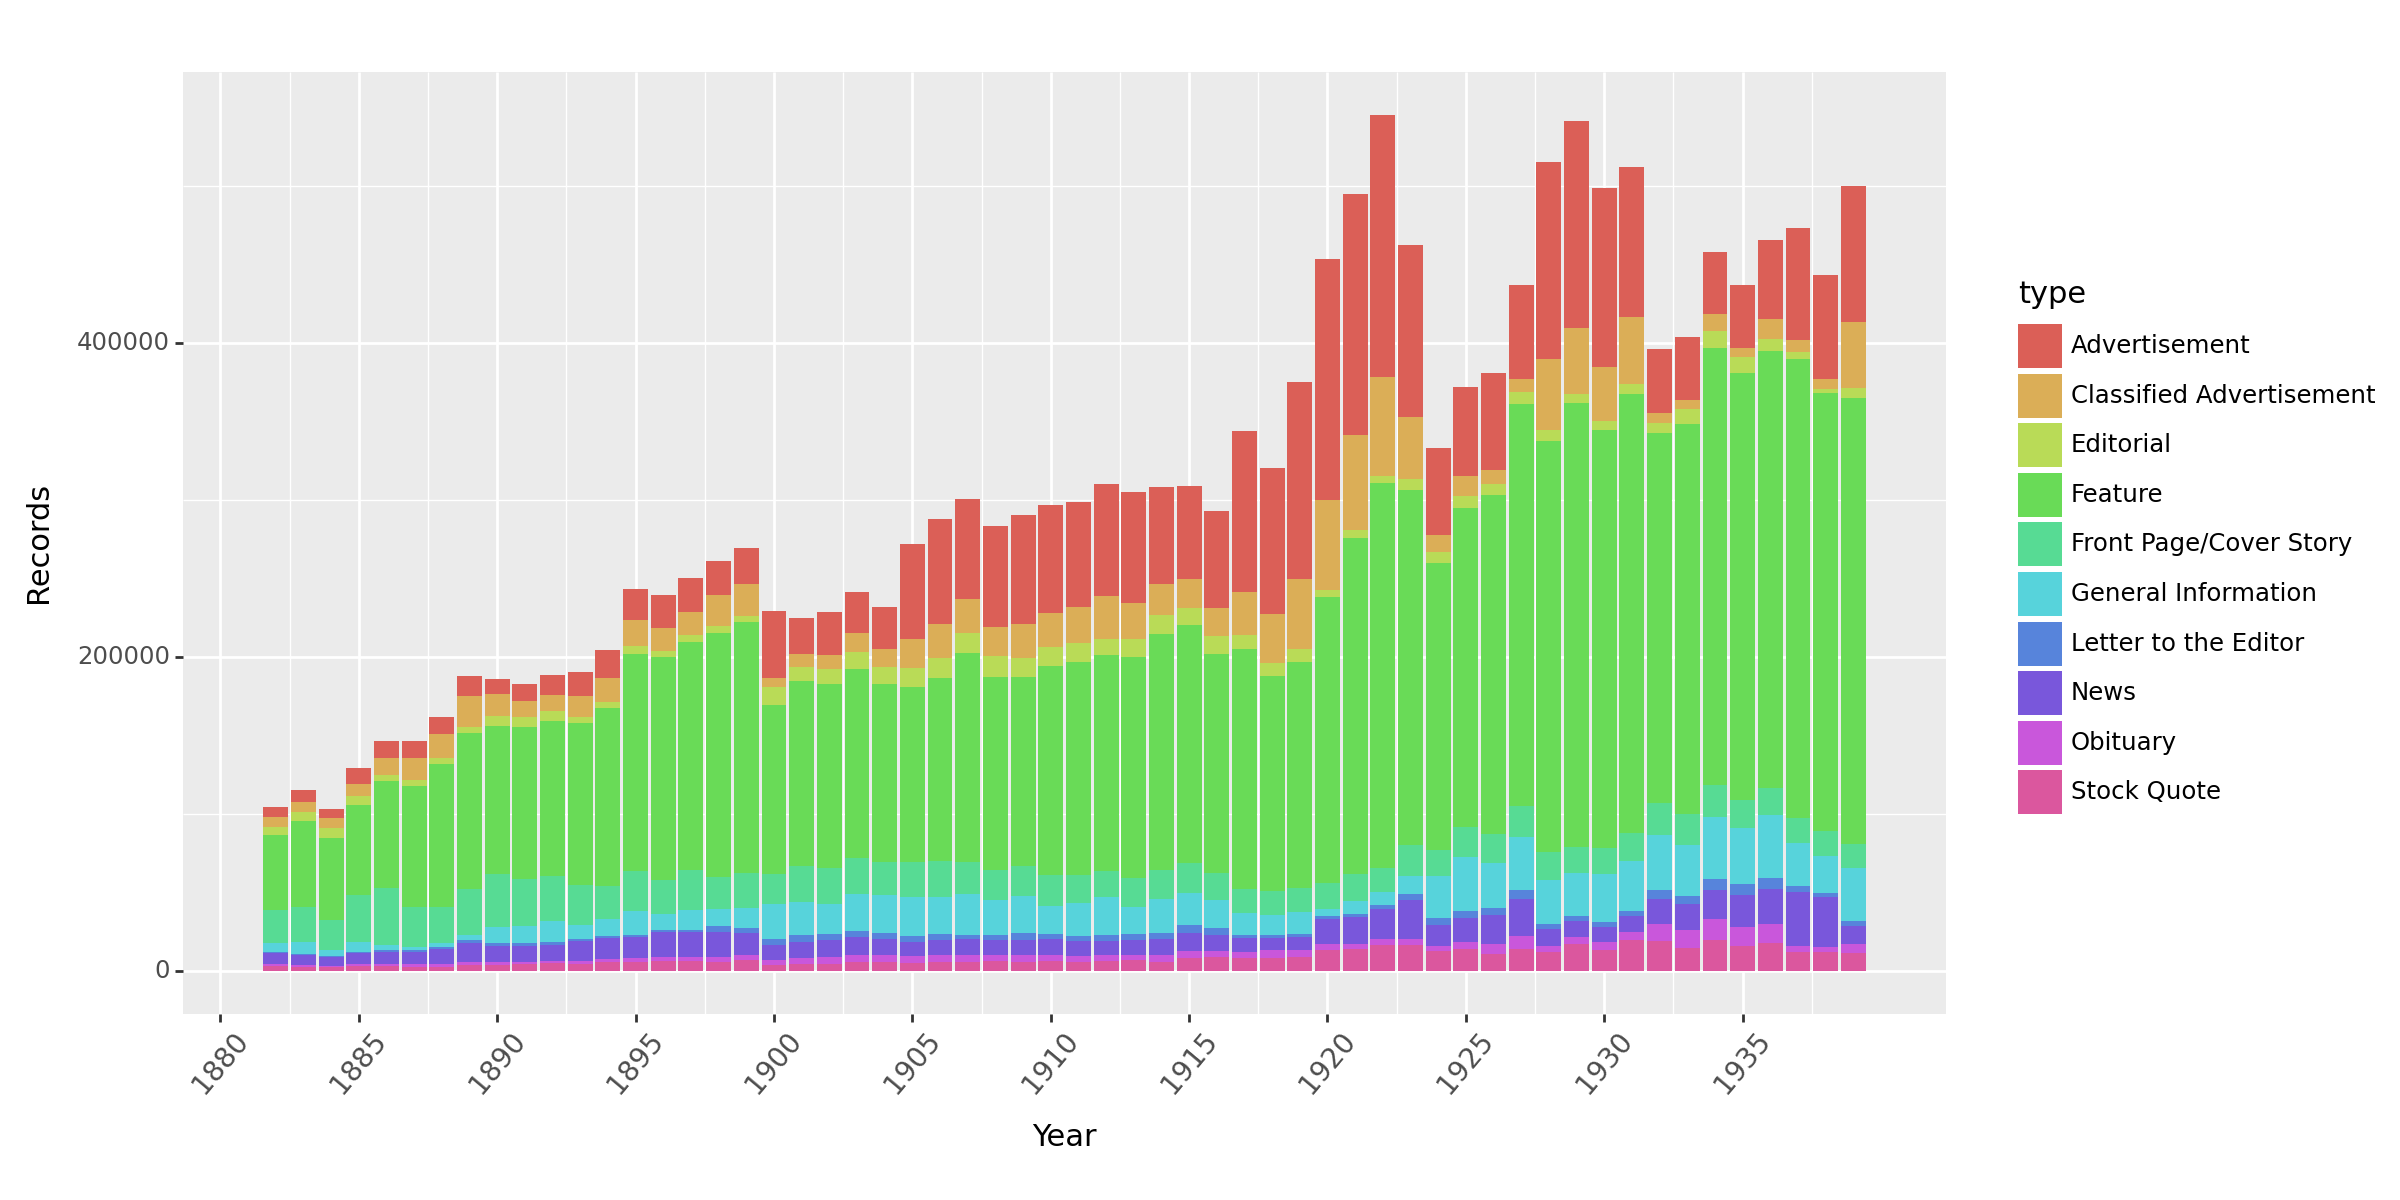

<Figure Size: (1200 x 600)>

In [14]:
myplot = (p9.ggplot(year_types2)
    + p9.geom_bar(mapping=p9.aes(x='year', fill='type', y='count'), stat='stat_identity')
    + p9.ylab("Records")
    + p9.scale_x_continuous(name="Year", breaks=range(1880,1940, 5))
    + p9.theme(axis_text_x = p9.element_text(size=10, angle=50)))
myplot

# Working with title text

Let's export a CSV of all the titles from 'Front Page/Cover Story' records on page 1 from 1900 to 1939.

In [15]:
q = """
SELECT recs.numeric_pubdate as date,
       CAST(SUBSTR(recs.numeric_pubdate,1,4) as INTEGER) as year,
       recs.object_type as type,
       recs.start_page as page,
       recs.pagination as pagination,
       recs.record_title as record_title,
       pubs.short as pub,
       recs.url_docview as url
FROM pqnews_records recs
INNER JOIN pqnews_publications pubs on recs.publication_id = pubs.id 
WHERE record_title NOT LIKE '%-- No Title' 
    AND year >= 1900 
    AND year <= 1939
    AND type = 'Front Page/Cover Story'
ORDER BY date ASC, pub ASC;
"""
titles = pd.read_sql_query(q,con)


In [16]:
titles.to_csv("output/frontpage-titles.csv", columns=['date','pub','record_title','url'])

OSError: Cannot save file into a non-existent directory: 'output'